In [2]:
import hydra
from omegaconf import DictConfig
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from hydra.utils import to_absolute_path
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from modulus.models.fno import FNO
from modulus.launch.logging import LaunchLogger
from modulus.launch.utils.checkpoint import save_checkpoint, load_checkpoint
#from modulus.sym.eq.pdes.diffusion import Diffusion

#from utils import HDF5MapStyleDataset
from ops import dx, ddx
import yaml
from munch import DefaultMunch

torch.cuda.empty_cache()

In [3]:
from data_init import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
total_size = 640
segment_to_skip = 100

train, val, test, norm_info = get_data()
X_train, X_train_normalized, y_train, y_train_normalized = train
X_val, X_val_normalized, y_val, y_val_normalized = val
X_test, X_test_normalized, y_test, y_test_normalized = test
X_normalization_info, y_normalization_info = norm_info
X_test_old, X_test_old_normalized, y_test_old, y_test_old_normalized = get_old_predicts(X_normalization_info, y_normalization_info)

# find sample where X_test[:, 0, :] != X_test_old[:, 0, :]
j = 0
index = 0
for i in range(X_test.shape[0]):
    if not torch.all(X_test[i, 0, :] == X_test_old[i + j, 0, :]):
        index = i
        j+=1

# delete index from X_test_old
X_test_old = torch.cat([X_test_old[:index], X_test_old[index + 1:]], dim=0)
X_test_old_normalized = torch.cat([X_test_old_normalized[:index], X_test_old_normalized[index + 1:]], dim=0)
y_test_old = torch.cat([y_test_old[:index], y_test_old[index + 1:]], dim=0)
y_test_old_normalized = torch.cat([y_test_old_normalized[:index], y_test_old_normalized[index + 1:]], dim=0)


In [4]:
def load_model(config_name):

    with open(f"./conf/{config_name}", 'r') as stream:
        cfg = DefaultMunch.fromDict(yaml.safe_load(stream))
        
    model = FNO(
        in_channels=cfg.model.fno.in_channels,
        out_channels=cfg.model.fno.out_channels,
        decoder_layers=cfg.model.fno.decoder_layers,
        decoder_layer_size=cfg.model.fno.decoder_layer_size,
        dimension=cfg.model.fno.dimension,
        latent_channels=cfg.model.fno.latent_channels,
        num_fno_layers=cfg.model.fno.num_fno_layers,
        num_fno_modes=cfg.model.fno.num_fno_modes,
        padding=cfg.model.fno.padding,
    )
    return cfg, model

In [5]:
from scipy.signal import butter, filtfilt

# Butterworth Low-pass Filter
def butter_lowpass_filter(data, cutoff, fs, order=5):    
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
    

In [21]:
model_type = 'fno'

def get_preds(path_config, path_checkpoint):
    cfg, model = load_model(path_config)
    load_checkpoint(path_checkpoint, models=[model])
    model.eval()
    y_pred_norm = model(X_test_normalized[:, :, :]).cpu().detach().numpy()
    del cfg, model

    y_pred_norm[:, 0, :], y_pred_norm[:, 1, :], y_pred_norm[:, 2, :] = butter_lowpass_filter(y_pred_norm[:, 0, :], 5, 300, 6).copy(), \
        butter_lowpass_filter(y_pred_norm[:, 1, :], 5, 300, 6).copy(), \
        butter_lowpass_filter(y_pred_norm[:, 2, :], 5, 300, 6).copy()
    
    return y_pred_norm


In [22]:
y_pred_baseline_norm, y_pred_mass_norm, y_pred_momentum_norm, y_pred_mass_momentum_norm = \
    get_preds(f"config_{model_type}.yaml", f'outputs_{model_type}/checkpoints'), \
    get_preds(f"config_pino_{model_type}_mass.yaml", f'outputs_pino_{model_type}_mass/checkpoints'), \
    get_preds(f"config_pino_{model_type}_mom.yaml", f'outputs_pino_{model_type}_mom/checkpoints'), \
    get_preds(f"config_pino_{model_type}_mom_mass.yaml", f'outputs_pino_{model_type}_mom_mass/checkpoints')

[13:41:19 - checkpoint - INFO] Loaded model state dictionary /home/biromiro/modulus/examples/exps/outputs_fno/checkpoints/FourierNeuralOperator.0.100.mdlus to device cpu
[13:41:19 - checkpoint - INFO] Loaded checkpoint file /home/biromiro/modulus/examples/exps/outputs_fno/checkpoints/checkpoint.0.100.pt to device cpu
[13:41:22 - checkpoint - INFO] Loaded model state dictionary /home/biromiro/modulus/examples/exps/outputs_pino_fno_mass/checkpoints/FourierNeuralOperator.0.265.mdlus to device cpu
[13:41:22 - checkpoint - INFO] Loaded checkpoint file /home/biromiro/modulus/examples/exps/outputs_pino_fno_mass/checkpoints/checkpoint.0.265.pt to device cpu
[13:41:25 - checkpoint - INFO] Loaded model state dictionary /home/biromiro/modulus/examples/exps/outputs_pino_fno_mom/checkpoints/FourierNeuralOperator.0.500.mdlus to device cpu
[13:41:25 - checkpoint - INFO] Loaded checkpoint file /home/biromiro/modulus/examples/exps/outputs_pino_fno_mom/checkpoints/checkpoint.0.500.pt to device cpu
[13:4

In [23]:
y_pred_baseline, y_pred_mass, y_pred_momentum, y_pred_mass_momentum = denormalize(torch.Tensor(y_pred_baseline_norm), y_normalization_info), \
    denormalize(torch.Tensor(y_pred_mass_norm), y_normalization_info), \
    denormalize(torch.Tensor(y_pred_momentum_norm), y_normalization_info), \
    denormalize(torch.Tensor(y_pred_mass_momentum_norm), y_normalization_info)

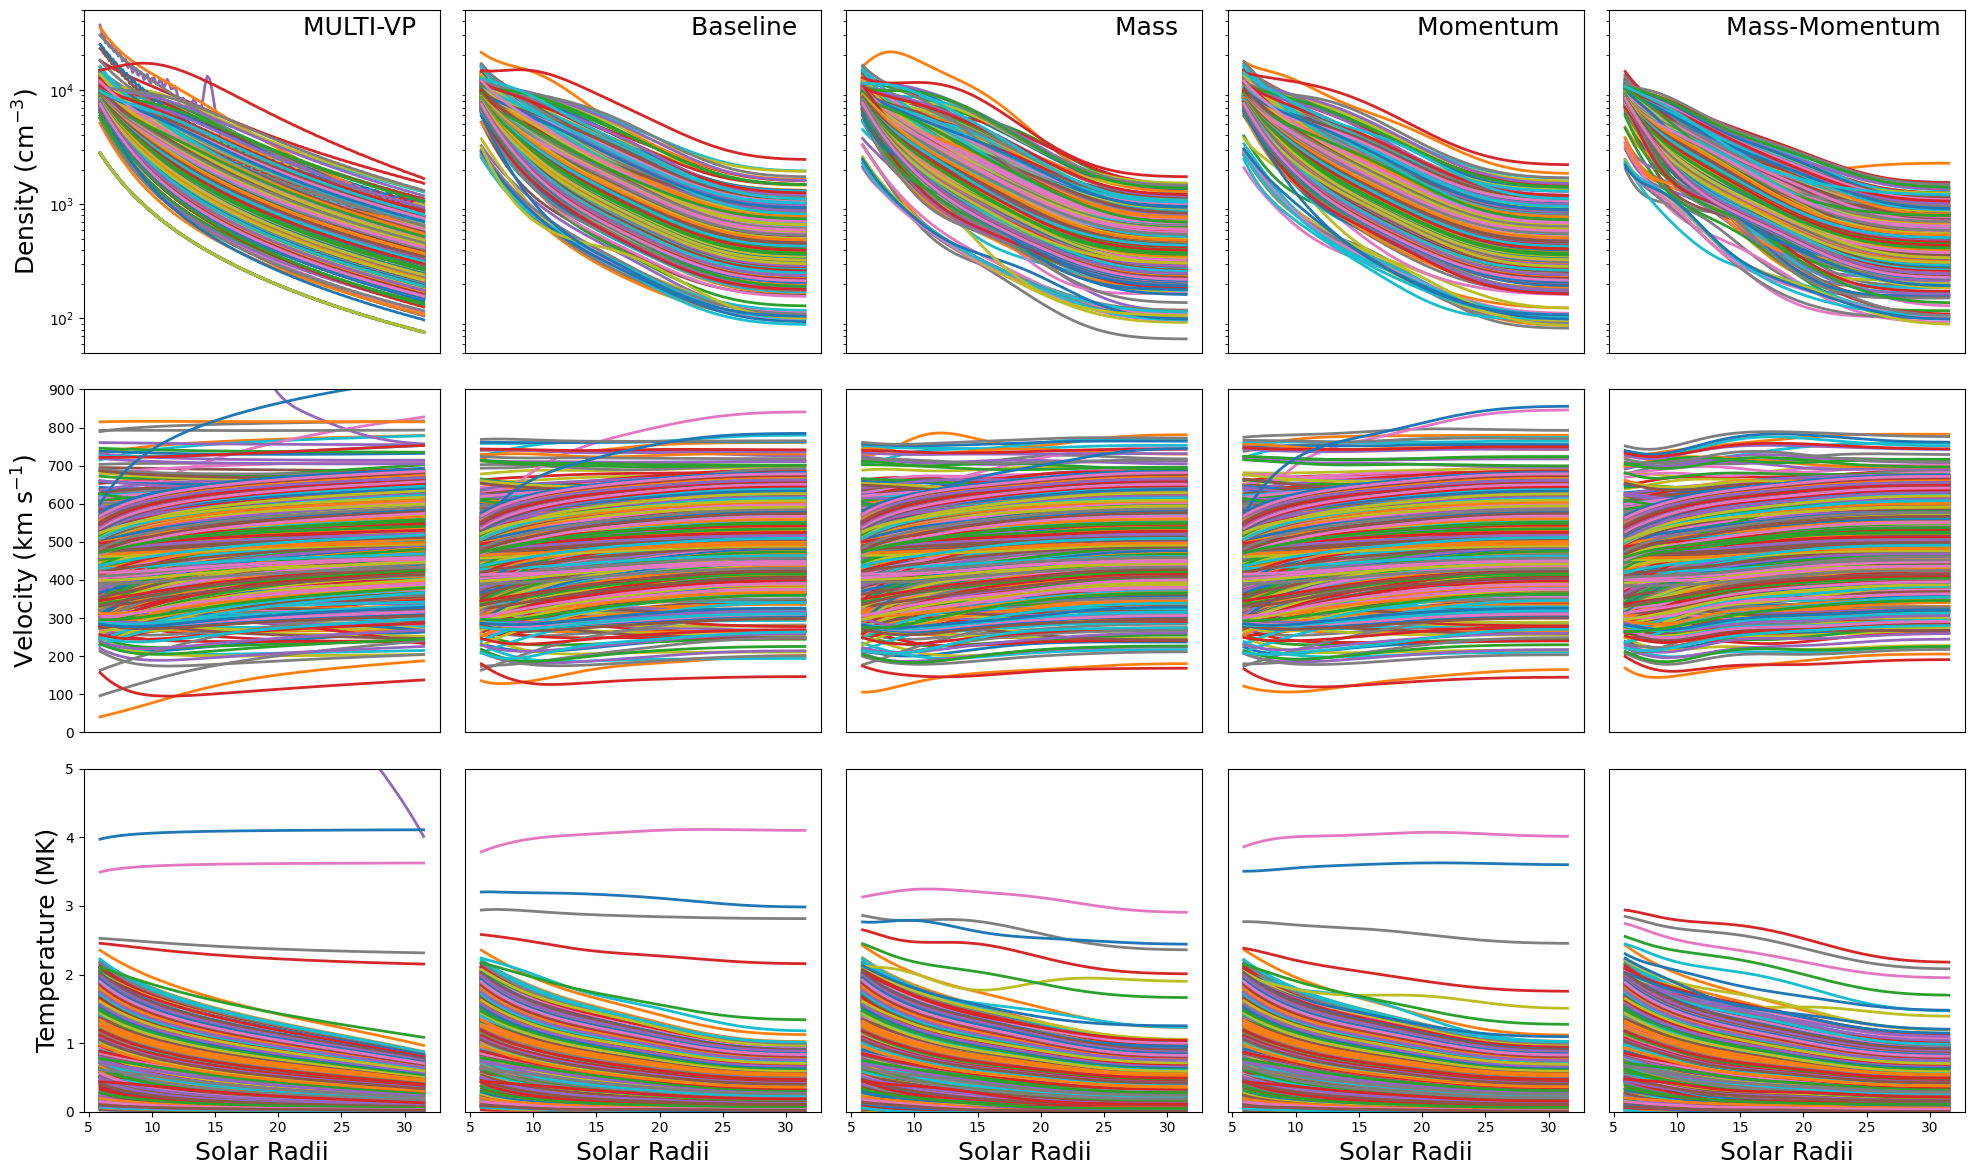

In [24]:
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
plt.rcParams.update({'font.size': 15, 'axes.titlesize' : 18, 'axes.labelsize' : 18, 'lines.linewidth' : 2, 'lines.markersize' : 10, 'xtick.labelsize' : 10, 'ytick.labelsize' : 10})
    # denormalize
output_names = ['n', 'v', 'T']
lims = [[50, 50000], [0, 900], [0, 5]]

for i in range(3):
    axs[i, 0].plot(X_test[:, 1, 400:].T, y_test[:, i, 400:].T)
    axs[i, 0].set_yscale('log') if i == 0 else None
    axs[i, 0].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 0].set_ylim(lims[i])
    #axs[i, 1].plot(X_test[:, 1, 400:].T, y_test_old[:, i, 400:].T)
    #axs[i, 1].set_yscale('log') if i == 0 else None
    #axs[i, 1].set_ylim(lims[i])
    axs[i, 1].plot(X_test[:, 1, 400:].T, y_pred_baseline[:, i, 400:].T)
    axs[i, 1].set_yscale('log') if i == 0 else None
    axs[i, 1].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 1].get_yaxis().set_ticks([])
    axs[i, 1].set_ylim(lims[i])
    axs[i, 2].plot(X_test[:, 1, 400:].T, y_pred_mass[:, i, 400:].T)
    axs[i, 2].set_yscale('log') if i == 0 else None
    axs[i, 2].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 2].get_yaxis().set_ticks([])
    axs[i, 2].set_ylim(lims[i])
    axs[i, 3].plot(X_test[:, 1, 400:].T, y_pred_momentum[:, i, 400:].T)
    axs[i, 3].set_yscale('log') if i == 0 else None
    axs[i, 3].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 3].set_ylim(lims[i])
    axs[i, 3].get_yaxis().set_ticks([])
    axs[i, 4].plot(X_test[:, 1, 400:].T, y_pred_mass_momentum[:, i, 400:].T)
    axs[i, 4].set_yscale('log') if i == 0 else None
    axs[i, 4].get_xaxis().set_ticks([]) if i != 2 else None
    axs[i, 4].set_ylim(lims[i])
    axs[i, 4].get_yaxis().set_ticks([])
    

    
axs[0, 0].set_title(f'MULTI-VP   ', y=1.0, pad=-18, loc='right')
#axs[0, 1].set_title(f'Old Baseline')
axs[0, 1].set_title(f'Baseline   ', y=1.0, pad=-18, loc='right')
axs[0, 2].set_title(f'Mass   ', y=1.0, pad=-18, loc='right')
axs[0, 3].set_title(f'Momentum   ', y=1.0, pad=-18, loc='right')
axs[0, 4].set_title(f'Mass-Momentum   ', y=1.0, pad=-18, loc='right')

axs[0, 0].set_ylabel('Density (cm$^{-3}$)')	
axs[1, 0].set_ylabel('Velocity (km s$^{-1}$)')
axs[2, 0].set_ylabel('Temperature (MK)')

axs[2, 0].set_xlabel('Solar Radii')
axs[2, 1].set_xlabel('Solar Radii')
axs[2, 2].set_xlabel('Solar Radii')
axs[2, 3].set_xlabel('Solar Radii')
axs[2, 4].set_xlabel('Solar Radii')
#axs[2, 5].set_xlabel('Solar Radii')

plt.tight_layout()
plt.show()

In [25]:
# calculate the coefficient of variation
def calculate_cv(y_pred):
    return torch.mean(torch.std(y_pred, axis=0) / torch.mean(y_pred, axis=0))

y_test_cv = calculate_cv(y_test[:, :, 400:])
y_test_old_cv = calculate_cv(y_test_old[:, :, 400:])
y_pred_baseline_cv = calculate_cv(torch.Tensor(y_pred_baseline[:, :, 400:]))
y_pred_mass_cv = calculate_cv(torch.Tensor(y_pred_mass[:, :, 400:]))
y_pred_momentum_cv = calculate_cv(torch.Tensor(y_pred_momentum[:, :, 400:]))
y_pred_mass_momentum_cv = calculate_cv(torch.Tensor(y_pred_mass_momentum[:, :, 400:]))

y_test_cv, y_test_old_cv, y_pred_baseline_cv, y_pred_mass_cv, y_pred_momentum_cv, y_pred_mass_momentum_cv

(tensor(0.3915987313),
 tensor(0.1302417964),
 tensor(0.3641093671),
 tensor(0.3632620275),
 tensor(0.3611319363),
 tensor(0.3365887702))

In [26]:
# calculate mse

def calculate_mse(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

y_test_mse = calculate_mse(y_test_normalized[:, :, 400:], y_test_normalized[:, :, 400:])
y_test_old_mse = calculate_mse(y_test_old_normalized[:, :, 400:], y_test_normalized[:, :, 400:])
y_pred_baseline_mse = calculate_mse(torch.Tensor(y_pred_baseline_norm[:, :, 400:]), y_test_normalized[:, :, 400:])
y_pred_mass_mse = calculate_mse(torch.Tensor(y_pred_mass_norm[:, :, 400:]), y_test_normalized[:, :, 400:])
y_pred_momentum_mse = calculate_mse(torch.Tensor(y_pred_momentum_norm[:, :, 400:]), y_test_normalized[:, :, 400:])
y_pred_mass_momentum_mse = calculate_mse(torch.Tensor(y_pred_mass_momentum_norm[:, :, 400:]), y_test_normalized[:, :, 400:])

y_test_mse, y_test_old_mse, y_pred_baseline_mse, y_pred_mass_mse, y_pred_momentum_mse, y_pred_mass_momentum_mse

(tensor(0.),
 tensor(0.2431410253),
 tensor(0.0365007520),
 tensor(0.0373581052),
 tensor(0.0356881358),
 tensor(0.0423466787))

In [27]:
# std of n*v/T should be 0 
y_test_nvt = y_test[:, 0, 400:] * y_test[:, 1, 400:] / y_test[:, 2, 400:]
y_test_old_nvt = y_test_old[:, 0, 400:] * y_test_old[:, 1, 400:] / y_test_old[:, 2, 400:]
y_pred_baseline_nvt = y_pred_baseline[:, 0, 400:] * y_pred_baseline[:, 1, 400:] / y_pred_baseline[:, 2, 400:]
y_pred_mass_nvt = y_pred_mass[:, 0, 400:] * y_pred_mass[:, 1, 400:] / y_pred_mass[:, 2, 400:]
y_pred_momentum_nvt = y_pred_momentum[:, 0, 400:] * y_pred_momentum[:, 1, 400:] / y_pred_momentum[:, 2, 400:]
y_pred_mass_momentum_nvt = y_pred_mass_momentum[:, 0, 400:] * y_pred_mass_momentum[:, 1, 400:] / y_pred_mass_momentum[:, 2, 400:]

y_test_nvt.shape, y_test_old_nvt.shape, y_pred_baseline_nvt.shape, y_pred_mass_nvt.shape, y_pred_momentum_nvt.shape

(torch.Size([1177, 140]),
 torch.Size([1177, 140]),
 torch.Size([1177, 140]),
 torch.Size([1177, 140]),
 torch.Size([1177, 140]))

In [28]:
torch.std(y_test_nvt, dim=1).mean(), \
torch.std(torch.Tensor(y_test_old_nvt), dim=1).mean(), \
torch.std(torch.Tensor(y_pred_baseline_nvt), dim=1).mean(), \
torch.std(torch.Tensor(y_pred_mass_nvt), dim=1).mean(), \
torch.std(torch.Tensor(y_pred_momentum_nvt), dim=1).mean(), \
torch.std(torch.Tensor(y_pred_mass_momentum_nvt), dim=1).mean()

(tensor(1477670.),
 tensor(584512.1250000000),
 tensor(54112092.),
 tensor(44146680.),
 tensor(12384171.),
 tensor(16085864.))

In [29]:
import torch

def lagrange_derivative(x, x0, x1, x2, y0, y1, y2):
    p0 = y0 * (2*x-x1-x2) / ((x0-x1)*(x0-x2))
    p1 = y1 * (2*x-x0-x2) / ((x1-x0)*(x1-x2))
    p2 = y2 * (2*x-x0-x1) / ((x2-x0)*(x2-x1))
    return p0 + p1 + p2

def cfd(x, y):
    """
    Adjusted function to compute the central first order derivative for uneven space sequences,
    with NaN handling without for loops.
    """
    d1 = torch.zeros_like(x)

    y0, y1, y2 = y[:, 0], y[:, 1], y[:, 2]
    x0, x1, x2 = x[:, 0], x[:, 1], x[:, 2]
    d1[:, 0] = lagrange_derivative(x0, x0, x1, x2, y0, y1, y2)

    y0, y1, y2 = y[:, :-2], y[:, 1:-1], y[:, 2:]
    x0, x1, x2 = x[:, :-2], x[:, 1:-1], x[:, 2:]
    d1[:, 1:-1] = lagrange_derivative(x1, x0, x1, x2, y0, y1, y2)

    y0, y1, y2 = y[:, -3], y[:, -2], y[:, -1]
    x0, x1, x2 = x[:, -3], x[:, -2], x[:, -1]
    d1[:, -1] = lagrange_derivative(x2, x0, x1, x2, y0, y1, y2)

    return d1

def csd(x, y):
    """
    Computes the central second order derivative for uneven space sequences
    without using for loops, including handling for NaN values.
    """
    d2 = torch.zeros_like(x)
    
    i = torch.arange(1, x.size(1) - 1)
    y0, y1, y2 = y[:, i-1], y[:, i], y[:, i+1]
    x0, x1, x2 = x[:, i-1], x[:, i], x[:, i+1]
    central_d2 = 2.0 * ((x1 - x0) * y2 - (x2 - x0) * y1 + (x2 - x1) * y0) / ((x1 - x0) * (x2 - x1) * (x2 - x0))
    d2[:, i] = central_d2
    
    d2[:, 0] = 2.0 * ((x[:, 1]-x[:, 0])*y[:, 2] - (x[:, 2]-x[:, 0])*y[:, 1] + (x[:, 2]-x[:, 1])*y[:, 0]) / \
              ((x[:, 1]-x[:, 0])*(x[:, 2]-x[:, 1])*(x[:, 2]-x[:, 0]))
    
    d2[:, -1] = 2.0 * ((x[:, -2]-x[:, -3])*y[:, -1] - (x[:, -1]-x[:, -3])*y[:, -2] + (x[:, -1]-x[:, -2])*y[:, -3]) / \
               ((x[:, -2]-x[:, -3])*(x[:, -1]-x[:, -2])*(x[:, -1]-x[:, -3]))

    return d2

In [30]:
DX_UN  =   6.96000e+10  # length unit factor (to cm)
VX_UN  =   1e+05 # speed unit factor (to cm/s)
TE_UN  =   1.00000e+06  # temperature unit factor (to K)
NE_UN  =   1.00000e+17  # density unit factor (to 1/cm^3)
DT_UN  =       5413.93  # time unit factor (to s)

NU_UN = (DX_UN**2)/DT_UN   # viscosity coeff init factor (to cm^2/s)

NU_VISC = .1 * NU_UN    # the actual viscosity coeff

In [32]:
class ConservationCriterion(torch.nn.Module):
    def __init__(self, normalization_info_inputs, normalization_info_outputs):
        super(ConservationCriterion, self).__init__()
        self.mse_loss = torch.nn.MSELoss()
        self.smooth_l1 = torch.nn.SmoothL1Loss()
        self.normalization_info_inputs = normalization_info_inputs
        self.normalization_info_outputs = normalization_info_outputs
        self.lambda_momentum = 0
        self.lambda_mass = 0
        self.G = 6.6743e-11
        self.nu_visc = NU_VISC
        
    def forward(self, inputs, preds):
        inputs_denormalized = denormalize(inputs, self.normalization_info_inputs)
        
        preds_denormalized = denormalize(preds, self.normalization_info_outputs)
        
        idx = 400 # why?
        
        R, L, a_a0, alpha = inputs_denormalized[:, 0, idx:] * DX_UN, inputs_denormalized[:, 1, idx:] * DX_UN, inputs_denormalized[:, 3, idx:] / DX_UN, inputs_denormalized[:, 4, idx:]
        n_pred, v_pred, T_pred = preds_denormalized[:, 0, idx:], preds_denormalized[:, 1, idx:] * VX_UN, preds_denormalized[:, 2, idx:] * TE_UN
                                            
        dnT_dL = cfd(L, n_pred * T_pred)
        dv2_dL = cfd(L, v_pred**2)
        dv_dL = cfd(L, v_pred)
        d2v_dL2 = csd(L, v_pred)
        gradp  = dnT_dL / n_pred

        gravf  = self.G * torch.cos(alpha) / R**2
        
        vgradva  = dv2_dL
        vgradvc  = -v_pred * dv_dL
        vgradv = vgradva + vgradvc 

        visca = d2v_dL2
        viscb = dv_dL * a_a0
        visc  = -self.nu_visc * (visca + viscb)
                
        momentum_loss = ((vgradv + gradp + visc + gravf)**2).nanmean().sqrt()

        return momentum_loss

In [34]:
criterion = ConservationCriterion(X_normalization_info, y_normalization_info)

momentum_loss_test = criterion(X_test_normalized, y_test_normalized)
momentum_loss_old = criterion(X_test_normalized, y_test_old_normalized)
momentum_loss_baseline = criterion(torch.Tensor(X_test_normalized), torch.Tensor(y_pred_baseline_norm))
momentum_loss_mass = criterion(torch.Tensor(X_test_normalized), torch.Tensor(y_pred_mass_norm))
momentum_loss_momentum = criterion(torch.Tensor(X_test_normalized), torch.Tensor(y_pred_momentum_norm))
momentum_loss_mass_momentum = criterion(torch.Tensor(X_test_normalized), torch.Tensor(y_pred_mass_momentum_norm))

momentum_loss_test, momentum_loss_old, momentum_loss_baseline, momentum_loss_mass, momentum_loss_momentum, momentum_loss_mass_momentum

(tensor(28422.1035156250),
 tensor(42739.7656250000),
 tensor(18387.1269531250),
 tensor(22213.1523437500),
 tensor(17833.8945312500),
 tensor(36920.1601562500))